##### Follow the instructions from ReadMe.txt to run the ipynb files without errors

In [2]:
# Importing libraries
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.transforms as T
from torchvision import datasets
from torchvision import utils
import torch.nn as nn
import torch.optim as optim

In [3]:
# Checking if gpu is available
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda', index=0)

In [4]:
# Defining hyperparameters
batch_size = 64
num_epochs = 1000
learning_rate = 1e-7
weight_decay = 1e-5
min_delta = 1e-7
patience = 50
num_workers = 8

In [5]:
# Creating tansforms to carry out image transformation
train_transforms = T.Compose([T.Grayscale(), 
                              T.Resize(256) , 
                              T.RandomRotation(20), 
                              T.RandomResizedCrop(240), 
                              T.RandomHorizontalFlip(), 
                              T.RandomVerticalFlip(), 
                              T.ToTensor(), 
                              T.Normalize([0.5], [0.5])])

test_transforms = T.Compose([T.Grayscale(), 
                             T.Resize(256), 
                             T.CenterCrop(240), 
                             T.ToTensor(), 
                             T.Normalize([0.5], [0.5])])

val_transforms = T.Compose([T.Grayscale(), 
                            T.Resize(256), 
                            T.CenterCrop(240), 
                            T.ToTensor(), 
                            T.Normalize([0.5], [0.5])])

train_data = datasets.ImageFolder('chest_xray/train', transform = train_transforms)

test_data = datasets.ImageFolder('chest_xray/test', transform = test_transforms)

val_data = datasets.ImageFolder('chest_xray/val', transform = val_transforms)

# Creating data loaders to load data in batches
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, 
                                           shuffle = True, num_workers=num_workers)

test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size, 
                                          shuffle = True, num_workers=num_workers)

val_loader = torch.utils.data.DataLoader(val_data, batch_size = batch_size, 
                                         shuffle = True, num_workers=num_workers)

In [6]:
# Creating convolutional neural network
class Cnn(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Convolution layer
        self.cnn = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding='same'),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=3),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding='same'),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=3),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding='same'),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=3),       
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding='same'),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=3),       
        )
        
        # Linear layer
        self.linear = nn.Sequential(
            nn.Linear(in_features=2048, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=2),  
        )
        
    def forward(self, x):
        x = self.cnn(x)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        return x

In [9]:
# Initializing the model
model = Cnn()

# Initializing the optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Initializing the loss function
criterion = nn.CrossEntropyLoss()

# Moving model to GPU if its available
if torch.cuda.is_available():
    model.to(device)
    criterion.to(device)
    
print(model)

Cnn(
  (cnn): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (13): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track

In [120]:
epochs = []
train_losses = []
test_losses = []
train_accu = []
test_accu = []
train_recalls = []
test_recalls = []
train_precisions = []
test_precisions = []
train_f1s = []
test_f1s = []
n = 0
m = patience
max_f1 = -1.0

# Training the CNN model
for e in range(num_epochs):
    train_loss = 0.0
    train_accuracy = 0.0
    train_total = 0.0
    train_target_true = 0.0
    train_predicted_true = 0.0
    train_correct_true = 0.0
    model.train()
    for img, labels in train_loader:
        if torch.cuda.is_available():
            img, labels = img.cuda(), labels.cuda()
        optimizer.zero_grad()
        pred = model(img)
        loss = criterion(pred,labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = pred.max(1)
        train_total += labels.size(0)
        train_accuracy += predicted.eq(labels).sum().item()
        train_predicted_classes = torch.argmax(pred, dim=1) == 1
        train_target_classes = labels
        train_target_true += torch.sum(train_target_classes == 1).float()
        train_predicted_true += torch.sum(train_predicted_classes).float()
        train_correct_true += torch.sum((train_predicted_classes==train_target_classes)*(train_predicted_classes==1)).float()
     
    test_loss = 0.0
    test_accuracy = 0.0
    test_total = 0.0
    test_target_true = 0.0
    test_predicted_true = 0.0
    test_correct_true = 0.0
    model.eval()
    with torch.no_grad():
        for img, labels in test_loader:
            if torch.cuda.is_available():
                img, labels = img.cuda(), labels.cuda()
            pred = model(img)
            loss = criterion(pred,labels)
            test_loss += loss.item()
            _, predicted = pred.max(1)
            test_total += labels.size(0)
            test_accuracy += predicted.eq(labels).sum().item()
            test_predicted_classes = torch.argmax(pred, dim=1) == 1
            test_target_classes = labels
            test_target_true += torch.sum(test_target_classes == 1).float()
            test_predicted_true += torch.sum(test_predicted_classes).float()
            test_correct_true += torch.sum((test_predicted_classes==test_target_classes)*(test_predicted_classes==1)).float()
            
    
    train_loss = train_loss / len(train_loader)
    test_loss =  test_loss / len(test_loader)
    train_accuracy = train_accuracy/train_total
    test_accuracy = test_accuracy/test_total
    train_precision = train_correct_true/train_predicted_true
    test_precision = test_correct_true/test_predicted_true
    train_recall = train_correct_true/train_target_true
    test_recall = test_correct_true/test_target_true
    train_precision = train_precision.detach().cpu().numpy()
    test_precision = test_precision.detach().cpu().numpy()
    train_recall = train_recall.detach().cpu().numpy()
    test_recall = test_recall.detach().cpu().numpy()
    train_f1_score = 2.0*train_precision*train_recall/(train_precision+train_recall)
    test_f1_score = 2.0*test_precision*test_recall/(test_precision+test_recall)
    
    epochs.append(e+1)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accu.append(train_accuracy)
    test_accu.append(test_accuracy)
    train_recalls.append(train_recall)
    test_recalls.append(test_recall)
    train_precisions.append(train_precision)
    test_precisions.append(test_precision)
    train_f1s.append(train_f1_score)
    test_f1s.append(test_f1_score)
    
    print(f'Epoch {e+1}:-')
    print(f'Training Loss:\t\t{train_loss}\tTest Loss:\t{test_loss}')
    print(f'Training Accuracy:\t{train_accuracy}\tTest Accuracy:\t{test_accuracy}')
    print(f'Training Precision:\t{train_precision}\tTest Precision:\t{test_precision}')
    print(f'Training Recall:\t{train_recall}\tTest Recall:\t{test_recall}')
    print(f'Training F1 Score:\t{train_f1_score}\tTest F1 Score:\t{test_f1_score}')
    
    if test_f1_score > max_f1:
        if test_f1_score - max_f1 >= min_delta:
            m = patience
            print(f'Test F1 score increased({max_f1}--->{test_f1_score}) \nSaving the model')
            torch.save(model.state_dict(), 'model.pth')
        else:
            m -= 1
            print(f'Test F1 score did not increase by value greater than {min_delta} \nPatience decreased to {m}')
        max_f1 = test_f1_score
    else:
        m -= 1
        print(f'Test F1 score did not increase \nPatience decreased to {m}')
        
    if m == 0:
        print('Ran out of patience! Stopping training early.')
        break
        
    if max_f1 == 1:
        torch.save(model.state_dict(), 'model.pth')
        print('Reached best F1 score! Stopping training early.')
        break

Epoch 1:-
Training Loss:		0.6749720486198983	Test Loss:	0.647773152589798
Training Accuracy:	0.6073619631901841	Test Accuracy:	0.7291666666666666
Training Precision:	0.7749022245407104	Test Precision:	0.8202898502349854
Training Recall:	0.6645161509513855	Test Recall:	0.7256410121917725
Training F1 Score:	0.7154765754081487	Test F1 Score:	0.7700680175059936
Test F1 score increased(-1.0--->0.7700680175059936) 
Saving the model
Epoch 2:-
Training Loss:		0.6485123721564688	Test Loss:	0.6356632769107818
Training Accuracy:	0.6995782208588958	Test Accuracy:	0.7307692307692307
Training Precision:	0.7691231369972229	Test Precision:	0.7534246444702148
Training Recall:	0.8510967493057251	Test Recall:	0.8461538553237915
Training F1 Score:	0.8080362217087438	Test F1 Score:	0.7971014460328495
Test F1 score increased(0.7700680175059936--->0.7971014460328495) 
Saving the model
Epoch 3:-
Training Loss:		0.6259555947489854	Test Loss:	0.6265680193901062
Training Accuracy:	0.7340874233128835	Test Accurac

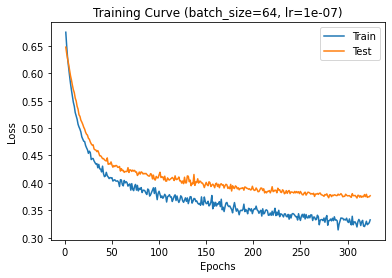

In [121]:
# Plotting training and test loss
plt.title("Training Curve (batch_size={}, lr={})".format(batch_size, learning_rate))
plt.plot(epochs, train_losses, label="Train")
plt.plot(epochs, test_losses, label="Test")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

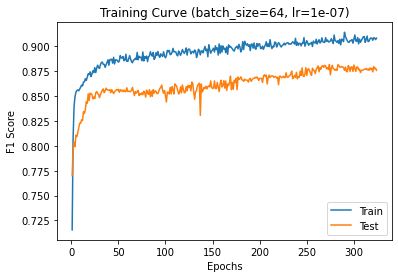

In [125]:
# Plotting train and test f1 score per epoch
plt.title("Training Curve (batch_size={}, lr={})".format(batch_size, learning_rate))
plt.plot(epochs, train_f1s, label="Train")
plt.plot(epochs, test_f1s, label="Test")
plt.xlabel("Epochs")
plt.ylabel("F1 Score")
plt.legend()
plt.show()

In [10]:
model = Cnn()
model.load_state_dict(torch.load('model.pth'))
if torch.cuda.is_available():
    model.to(device)
model.state_dict()

OrderedDict([('cnn.0.weight',
              tensor([[[[ 0.3198, -0.0652, -0.2362],
                        [ 0.2637,  0.1137, -0.3311],
                        [-0.0761, -0.0617, -0.2461]]],
              
              
                      [[[-0.2080,  0.3224, -0.2266],
                        [-0.3306, -0.2540,  0.2184],
                        [ 0.1555,  0.1286, -0.0224]]],
              
              
                      [[[-0.0642,  0.0381,  0.0217],
                        [-0.1222, -0.1077,  0.1056],
                        [ 0.3252, -0.3009, -0.1093]]],
              
              
                      [[[ 0.2106, -0.1146, -0.1396],
                        [ 0.2001,  0.1357,  0.0498],
                        [ 0.0548,  0.1408, -0.2948]]],
              
              
                      [[[ 0.3333,  0.1235,  0.2219],
                        [ 0.3242,  0.0226,  0.3148],
                        [ 0.2547, -0.0781,  0.0600]]],
              
              
               

In [11]:
test_loss = 0.0
test_accuracy = 0.0
test_total = 0.0
test_target_true = 0.0
test_predicted_true = 0.0
test_correct_true = 0.0
model.eval()
with torch.no_grad():
    for img, labels in test_loader:
        if torch.cuda.is_available():
            img, labels = img.cuda(), labels.cuda()
        pred = model(img)
        loss = criterion(pred,labels)
        test_loss += loss.item()
        _, predicted = pred.max(1)
        test_total += labels.size(0)
        test_accuracy += predicted.eq(labels).sum().item()
        test_predicted_classes = torch.argmax(pred, dim=1) == 1
        test_target_classes = labels
        test_target_true += torch.sum(test_target_classes == 1).float()
        test_predicted_true += torch.sum(test_predicted_classes).float()
        test_correct_true += torch.sum((test_predicted_classes==test_target_classes)*(test_predicted_classes==1)).float()


test_loss =  test_loss / len(test_loader)
test_accuracy = test_accuracy/test_total
test_precision = test_correct_true/test_predicted_true
test_recall = test_correct_true/test_target_true
test_precision = test_precision.detach().cpu().numpy()
test_recall = test_recall.detach().cpu().numpy()
test_f1_score = 2.0*test_precision*test_recall/(test_precision+test_recall)

print(f'Test Loss:\t{test_loss}')
print(f'Test Accuracy:\t{test_accuracy}')
print(f'Test Precision:\t{test_precision}')
print(f'Test Recall:\t{test_recall}')
print(f'Test F1 Score:\t{test_f1_score}')
    

Test Loss:	0.3786422789096832
Test Accuracy:	0.8541666666666666
Test Precision:	0.8944591283798218
Test Recall:	0.8692307472229004
Test F1 Score:	0.8816645004057047
